# XGBoost Parameter Tuning for Otto Dataset

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

# 第二步：调整树的参数：max_depth & min_child_weight
(粗调，参数的步长为2；下一步是在粗调最佳参数周围，将步长降为1，进行精细调整)

首先 import 必要的模块

In [1]:
import sys
sys.path.append('/mnt/wc/xgboost/python-package')
# sys.path

In [2]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [3]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

In [3]:
#sns.countplot(train.target);
#pyplot.xlabel('target');
#pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [4]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [5]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

第一轮参数调整得到的n_estimators最优值（699），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss，neg_mean_squared_error 详见sklearn文档：http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

In [8]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = [8,9,10]
min_child_weight = [0.5,1,2]
param_test2_2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_2

{'max_depth': [8, 9, 10], 'min_child_weight': [0.5, 1, 2]}

In [ ]:
# Best: -1.793721 using {'max_depth': 9, 'min_child_weight': 1}

In [10]:
xgb2_2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=2,  #第一轮参数调整得到的n_estimators最优值
        max_depth=9,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        n_jobs= -1)


gsearch2_2 = GridSearchCV(xgb2_2, param_grid = param_test2_2, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_2.fit(X_train , y_train)

gsearch2_2.grid_scores_, gsearch2_2.best_params_,     gsearch2_2.best_score_

/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1.80567, std: 0.00121, params: {'max_depth': 8, 'min_child_weight': 0.5},
  mean: -1.80693, std: 0.00145, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: -1.81191, std: 0.00289, params: {'max_depth': 8, 'min_child_weight': 2},
  mean: -1.79080, std: 0.00519, params: {'max_depth': 9, 'min_child_weight': 0.5},
  mean: -1.79372, std: 0.00692, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -1.79763, std: 0.00681, params: {'max_depth': 9, 'min_child_weight': 2},
  mean: -1.80074, std: 0.00195, params: {'max_depth': 10, 'min_child_weight': 0.5},
  mean: -1.79912, std: 0.00671, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: -1.80382, std: 0.00547, params: {'max_depth': 10, 'min_child_weight': 2}],
 {'max_depth': 9, 'min_child_weight': 0.5},
 -1.7907999047631495)

In [11]:
gsearch2_2.cv_results_

/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anac

{'mean_fit_time': array([2.63821301, 1.8711812 , 1.49896889, 1.98387418, 1.80291429,
        1.72069783, 2.61584482, 2.15046825, 1.70516658]),
 'mean_score_time': array([0.03580327, 0.04070625, 0.03608394, 0.03719344, 0.0359436 ,
        0.03908186, 0.03336096, 0.03179913, 0.01896038]),
 'mean_test_score': array([-1.80566715, -1.806929  , -1.81191232, -1.7907999 , -1.79372056,
        -1.79763326, -1.80073788, -1.7991237 , -1.80381887]),
 'mean_train_score': array([-2.10276781, -2.17979425, -2.03061557, -2.18000145, -2.17995286,
        -2.17981659, -2.18042673, -2.02346291, -2.02672089]),
 'param_max_depth': masked_array(data=[8, 8, 8, 9, 9, 9, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[0.5, 1, 2, 0.5, 1, 2, 0.5, 1, 2],
              mask=[False, False, False, False, False, False, False, False,
                    F

Best: -1.790800 using {'max_depth': 9, 'min_child_weight': 0.5}


/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anacond

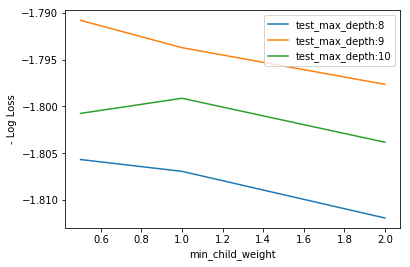

In [13]:
# summarize results
print("Best: %f using %s" % (gsearch2_2.best_score_, gsearch2_2.best_params_))
test_means = gsearch2_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_2.cv_results_[ 'std_test_score' ]
train_means = gsearch2_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_2.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_2.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_2.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth),len(min_child_weight))
train_scores = np.array(train_means).reshape(len(max_depth),len(min_child_weight))

for i, value in enumerate(max_depth):
    pyplot.plot(min_child_weight, test_scores[i], label= 'test_max_depth:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'min_child_weight' )                                                                                                      
pyplot.ylabel( '- Log Loss' )
pyplot.savefig( 'max_depth_vs_min_child_weght2.png' )